### Gymnasium links

Announce: https://farama.org/Announcing-The-Farama-Foundation

Github: https://github.com/Farama-Foundation/Gymnasium

Documentation: https://gymnasium.farama.org/

# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__


In [ ]:
# Install gymnasium if you don't have
!pip install gymnasium
!pip install gymnasium[toy_text]
!pip install gymnasium[classic_control]
!pip install imageio_ffmpeg
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 836 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 23.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 1.8 MB 34.6 MB/s 


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neural_network import MLPRegressor


np.random.seed(19)

### Bonus tasks (up to 0.5 points)

* __2.3 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v1"](https://gymnasium.farama.org/environments/classic_control/pendulum/) __(score -150)__.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Solve [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) __(score +90)__ or [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) __(score -200)__. Slightly less points for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.
  * __Please list what you did in anytask submission form__

## Обучение LunarLanderContinuous-v2:

state vector dim = 8


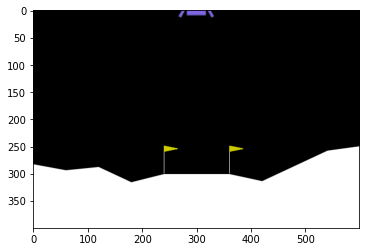

In [ ]:
env_lander = gym.make("LunarLanderContinuous-v2", render_mode="rgb_array").env

env_lander.reset(seed=19)
# n_actions = env_lander.action_space.n
state_dim = env_lander.observation_space.shape[0]

plt.imshow(env_lander.render())
print("state vector dim =", state_dim)
# print("n_actions =", n_actions)

env_lander.close()

In [ ]:
agent_lander = MLPRegressor(
    hidden_layer_sizes=(20, 20),
    activation='identity'
)

agent_lander.partial_fit(env_lander.reset()[0].reshape(1, -1), np.random.randint(low=-500, high=500, size=8).reshape(1, -1))

MLPRegressor(activation='identity', hidden_layer_sizes=(20, 20))

In [ ]:
def generate_session(agent, env, sigma=1, t_max=10**4, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset(seed=19)

    for t in range(t_max):
        
        probs = np.squeeze(agent.predict([s]))

        if test:
            a = probs
        else:
            a = probs + sigma * np.random.randn(1)

        new_s, r, done, info, _ = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [ ]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, q=percentile)

    elite_states, elite_actions = [], []
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] > reward_threshold:
            elite_actions.extend(actions_batch[i])
            elite_states.extend(states_batch[i])

    # Let's see that it differs from tabular `select_elites`.
    # Our neural network now is trained with one object and it takes an input of `(1, n_states)`.
    # So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.
    
    return elite_states, elite_actions

In [ ]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    clear_output(True)
    plt.show()

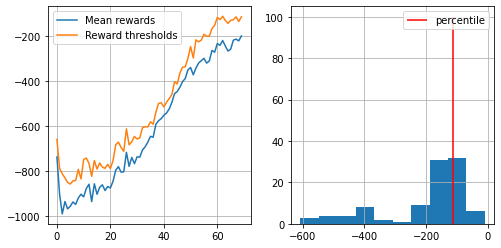

You Win! You may stop training now.
Total time: 0:14:04.306898


In [ ]:
# %%time
from datetime import datetime as dt
start_time = dt.now()

n_sessions = 100
percentile = 70
log = []

for i in range(200):
    # generate new sessions
    sessions = [generate_session(agent_lander, env_lander) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, 
                                                rewards_batch, percentile)

    agent_lander.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

    if np.mean(rewards_batch) > -200:
        print("You Win! You may stop training now.")
        break

print(f'Total time: {dt.now() - start_time}')

## Обучение Pendulum-v1:

state vector dim = 3


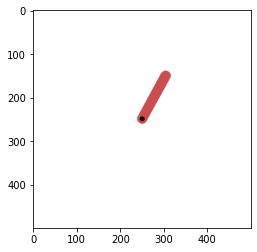

In [ ]:
env_pendulum = gym.make("Pendulum-v1", render_mode="rgb_array").env

env_pendulum.reset(seed=19)
# n_actions = env_pendulum.action_space.n
state_dim = env_pendulum.observation_space.shape[0]

plt.imshow(env_pendulum.render())
print("state vector dim =", state_dim)
# print("n_actions =", n_actions)

env_pendulum.close()

In [ ]:
agent_pendulum = MLPRegressor(
    hidden_layer_sizes=(16, 128, 16),
    activation='tanh',
)

agent_pendulum.partial_fit(env_pendulum.reset()[0].reshape(1, -1), np.random.randint(low=-1, high=1, size=3).reshape(1, -1))

MLPRegressor(activation='tanh', hidden_layer_sizes=(16, 128, 16))

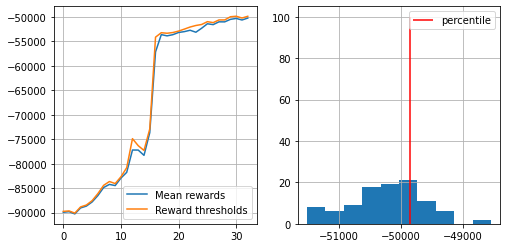

In [ ]:
# %%time
from datetime import datetime as dt
start_time = dt.now()

n_sessions = 100
percentile = 70
log = []

for i in range(200):
    # generate new sessions
    sessions = [generate_session(agent_pendulum, env_pendulum) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, 
                                                rewards_batch, percentile)

    agent_pendulum.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now.")
        break

print(f'Total time: {dt.now() - start_time}')

#### Вывод: у маятника тенденция к сходимости за 100-200 итераций есть, однако каждая длится долго и колаб отключается.
